# 第42章: 条件付き生成とClassifier-Free Guidance

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 条件付き拡散モデルを理解できる
- [ ] Classifier-Free Guidanceを実装できる
- [ ] 特定のクラス（数字）を生成できる
- [ ] ガイダンススケールの効果を理解できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 37-41（拡散モデルの基礎と実装）

⏱️ **推定学習時間**: 150-180分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 実践

---

## 🌟 はじめに

これまでの拡散モデルは**無条件生成**でした。つまり、どんな画像が生成されるかを制御できませんでした。

### 🤔 条件付き生成とは？

**条件付き生成**: 「この数字を生成してください」のように、出力を制御

```
無条件: ノイズ → ランダムな数字
条件付き: ノイズ + "7" → 数字7の画像
```

### 📊 条件付き生成の手法

| 手法 | 説明 | 利点 | 欠点 |
|------|------|------|------|
| Classifier Guidance | 分類器で勾配を計算 | 事後適用可能 | 分類器が必要 |
| **Classifier-Free Guidance** | 条件付き/無条件を同時訓練 | シンプル、効果的 | 訓練が必要 |

### 💡 Classifier-Free Guidance (CFG)

**アイデア**: 条件付きと無条件の出力を組み合わせ

$$\tilde{\epsilon}_\theta(x_t, t, c) = \epsilon_\theta(x_t, t, \emptyset) + w \cdot (\epsilon_\theta(x_t, t, c) - \epsilon_\theta(x_t, t, \emptyset))$$

- $c$: 条件（クラスラベル）
- $\emptyset$: 無条件（空の条件）
- $w$: ガイダンススケール（通常 1.0〜7.5）

In [1]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. 条件付きU-Netの実装

クラスラベルを条件として受け取るU-Netを実装します。

In [2]:
# ============================================================
# 基本コンポーネント
# ============================================================

class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class TimeConditionedConvBlock(nn.Module):
    """タイムステップとクラス条件付き畳み込みブロック"""
    
    def __init__(self, in_channels, out_channels, emb_dim, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.activation = nn.SiLU()
        
        # 時間+クラス埋め込みの射影
        self.emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )
        
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x, emb):
        residual = self.residual_conv(x)
        x = self.activation(self.norm1(self.conv1(x)))
        emb = self.emb_proj(emb)[:, :, None, None]
        x = x + emb
        x = self.activation(self.norm2(self.conv2(x)))
        return x + residual


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

print("✅ 基本コンポーネントを定義しました")

✅ 基本コンポーネントを定義しました


In [3]:
# ============================================================
# 条件付きU-Net
# ============================================================

class ConditionalUNet(nn.Module):
    """
    条件付きU-Net（Classifier-Free Guidance対応）
    
    クラスラベルとタイムステップを条件として受け取る
    """
    
    def __init__(self, in_channels=1, out_channels=1, 
                 num_classes=10,  # MNISTのクラス数
                 time_dim=128, 
                 base_channels=64, 
                 channel_mults=(1, 2, 4)):
        super().__init__()
        
        self.time_dim = time_dim
        self.num_classes = num_classes
        
        # タイムステップ埋め込み
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        
        # クラス埋め込み（+1 は無条件用のNULLトークン）
        self.class_embed = nn.Embedding(num_classes + 1, time_dim)
        
        # 初期畳み込み
        self.init_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        # エンコーダ
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        
        channels = [base_channels * m for m in channel_mults]
        in_ch = base_channels
        
        for i, out_ch in enumerate(channels):
            self.down_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
            if i < len(channels) - 1:
                self.down_samples.append(Downsample(out_ch))
            in_ch = out_ch
        
        # ボトルネック
        self.mid_block = TimeConditionedConvBlock(channels[-1], channels[-1], time_dim)
        
        # デコーダ
        self.up_samples = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        
        reversed_channels = list(reversed(channels))

        for i, out_ch in enumerate(reversed_channels):
            if i == 0:
                # 最初のブロック：ボトルネックからの入力のみ
                in_ch = reversed_channels[0]
            else:
                # 前のブロックの出力 + スキップ接続
                in_ch = reversed_channels[i-1] + channels[len(channels)-1-i]
            if i > 0:
                self.up_samples.append(Upsample(reversed_channels[i-1]))
            self.up_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
        
        # 最終畳み込み
        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
        )
    
    def forward(self, x, t, class_labels=None):
        """
        Parameters:
        -----------
        x : Tensor, shape (B, C, H, W)
            ノイズ画像
        t : Tensor, shape (B,)
            タイムステップ
        class_labels : Tensor, shape (B,) or None
            クラスラベル（0-9）。Noneまたは num_classes の場合は無条件
        """
        batch_size = x.shape[0]
        
        # タイムステップ埋め込み
        t_emb = self.time_embed(t.float())
        
        # クラス埋め込み
        if class_labels is None:
            # 無条件: NULLトークン（num_classes）を使用
            class_labels = torch.full((batch_size,), self.num_classes, device=x.device, dtype=torch.long)
        c_emb = self.class_embed(class_labels)
        
        # 時間 + クラス埋め込みを結合
        emb = t_emb + c_emb
        
        # U-Net
        x = self.init_conv(x)
        
        skip_connections = []
        for i, block in enumerate(self.down_blocks):
            x = block(x, emb)
            skip_connections.append(x)
            if i < len(self.down_samples):
                x = self.down_samples[i](x)
        
        x = self.mid_block(x, emb)
        
        for i, block in enumerate(self.up_blocks):
            if i > 0:
                x = self.up_samples[i-1](x)
                skip = skip_connections[-(i+1)]
                x = torch.cat([x, skip], dim=1)
            x = block(x, emb)
        
        return self.final_conv(x)

# テスト
model = ConditionalUNet(num_classes=10).to(device)
x = torch.randn(4, 1, 28, 28, device=device)
t = torch.randint(0, 1000, (4,), device=device)
c = torch.randint(0, 10, (4,), device=device)

# 条件付き
out_cond = model(x, t, c)
print(f"条件付き出力: {out_cond.shape}")

# 無条件
out_uncond = model(x, t, None)
print(f"無条件出力: {out_uncond.shape}")

print(f"\n総パラメータ数: {sum(p.numel() for p in model.parameters()):,}")

条件付き出力: torch.Size([4, 1, 28, 28])
無条件出力: torch.Size([4, 1, 28, 28])

総パラメータ数: 5,591,361


---

## 2. Classifier-Free Guidance付きDDPM

In [4]:
# ============================================================
# CFG付きDDPMクラス
# ============================================================

class CFGDiffusion:
    """
    Classifier-Free Guidance付き拡散モデル
    """
    
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, 
                 p_uncond=0.1, device='cpu'):
        """
        Parameters:
        -----------
        model : nn.Module
            条件付きU-Net
        p_uncond : float
            訓練時に無条件にする確率（通常 0.1-0.2）
        """
        self.model = model
        self.T = T
        self.p_uncond = p_uncond
        self.device = device
        
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
        self.alpha_bars_prev = F.pad(self.alpha_bars[:-1], (1, 0), value=1.0)
        self.posterior_variance = self.betas * (1 - self.alpha_bars_prev) / (1 - self.alpha_bars)
    
    def q_sample(self, x_0, t, noise=None):
        """前方拡散"""
        if noise is None:
            noise = torch.randn_like(x_0)
        alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, noise
    
    def compute_loss(self, x_0, class_labels):
        """
        訓練損失を計算（CFG用）
        
        確率 p_uncond で無条件訓練（ラベルをドロップ）
        """
        batch_size = x_0.shape[0]
        
        # ランダムなタイムステップ
        t = torch.randint(0, self.T, (batch_size,), device=self.device)
        
        # 前方拡散
        x_t, noise = self.q_sample(x_0, t)
        
        # ランダムにラベルをドロップ（無条件訓練）
        drop_mask = torch.rand(batch_size, device=self.device) < self.p_uncond
        # ドロップされたラベルは num_classes（NULLトークン）に置き換え
        class_labels_dropped = class_labels.clone()
        class_labels_dropped[drop_mask] = self.model.num_classes
        
        # ノイズを予測
        noise_pred = self.model(x_t, t, class_labels_dropped)
        
        return F.mse_loss(noise_pred, noise)
    
    @torch.no_grad()
    def p_sample(self, x_t, t, class_labels, guidance_scale=7.5):
        """
        CFGを使った1ステップサンプリング
        
        guidance_scale: ガイダンスの強さ（1.0 = 条件付きのみ、大きいほど強い誘導）
        """
        batch_size = x_t.shape[0]
        t_tensor = torch.full((batch_size,), t, device=self.device, dtype=torch.long)
        
        if guidance_scale == 1.0:
            # ガイダンスなし（条件付きのみ）
            noise_pred = self.model(x_t, t_tensor, class_labels)
        else:
            # CFG: 条件付きと無条件の両方を計算
            # 条件付き
            noise_pred_cond = self.model(x_t, t_tensor, class_labels)
            # 無条件
            noise_pred_uncond = self.model(x_t, t_tensor, None)
            
            # CFG式: ε̃ = ε_uncond + w * (ε_cond - ε_uncond)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        
        # 係数
        alpha_t = self.alphas[t]
        alpha_bar_t = self.alpha_bars[t]
        beta_t = self.betas[t]
        
        # 平均
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred
        )
        
        if t > 0:
            noise = torch.randn_like(x_t)
            sigma_t = torch.sqrt(self.posterior_variance[t])
            x_prev = mean + sigma_t * noise
        else:
            x_prev = mean
        
        return x_prev
    
    @torch.no_grad()
    def sample(self, class_labels, guidance_scale=7.5, shape=None):
        """
        条件付きサンプリング
        
        Parameters:
        -----------
        class_labels : Tensor, shape (B,)
            生成したいクラス（0-9）
        guidance_scale : float
            ガイダンスの強さ
        """
        batch_size = class_labels.shape[0]
        
        if shape is None:
            shape = (batch_size, 1, 28, 28)
        
        # ノイズから開始
        x = torch.randn(shape, device=self.device)
        
        for t in tqdm(reversed(range(self.T)), total=self.T, desc='Sampling'):
            x = self.p_sample(x, t, class_labels, guidance_scale)
        
        return x

print("✅ CFGDiffusionクラスを定義しました")

✅ CFGDiffusionクラスを定義しました


---

## 3. 訓練

In [5]:
# ============================================================
# データセット準備
# ============================================================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# サブセット
subset_size = 10000
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = Subset(train_dataset, indices)

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"データセットサイズ: {len(train_subset):,}")

データセットサイズ: 10,000


In [6]:
# ============================================================
# 訓練
# ============================================================

# モデル
model = ConditionalUNet(
    in_channels=1, out_channels=1,
    num_classes=10,
    time_dim=128, base_channels=64, channel_mults=(1, 2, 4)
).to(device)

# CFG拡散
cfg_diffusion = CFGDiffusion(
    model, T=1000, 
    p_uncond=0.1,  # 10%の確率で無条件訓練
    device=device
)

# オプティマイザ
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# 訓練
num_epochs = 25
losses = []

print("訓練開始...")
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch, labels in pbar:
        batch = batch.to(device)
        labels = labels.to(device)
        
        loss = cfg_diffusion.compute_loss(batch, labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

print("✅ 訓練完了")

訓練開始...


Epoch 1/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 1: Loss = 0.1667


Epoch 2/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 2: Loss = 0.0518


Epoch 3/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 3: Loss = 0.0428


Epoch 4/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 4: Loss = 0.0387


Epoch 5/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 5: Loss = 0.0373


Epoch 6/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 6: Loss = 0.0333


Epoch 7/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 7: Loss = 0.0319


Epoch 8/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 8: Loss = 0.0313


Epoch 9/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 9: Loss = 0.0299


Epoch 10/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 10: Loss = 0.0298


Epoch 11/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 11: Loss = 0.0285


Epoch 12/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 12: Loss = 0.0277


Epoch 13/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 13: Loss = 0.0268


Epoch 14/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 14: Loss = 0.0284


Epoch 15/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 15: Loss = 0.0272


Epoch 16/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 16: Loss = 0.0268


Epoch 17/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 17: Loss = 0.0267


Epoch 18/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 18: Loss = 0.0263


Epoch 19/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 19: Loss = 0.0254


Epoch 20/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 20: Loss = 0.0258


Epoch 21/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 21: Loss = 0.0259


Epoch 22/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 22: Loss = 0.0261


Epoch 23/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 23: Loss = 0.0250


Epoch 24/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 24: Loss = 0.0258


Epoch 25/25:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 25: Loss = 0.0248
✅ 訓練完了


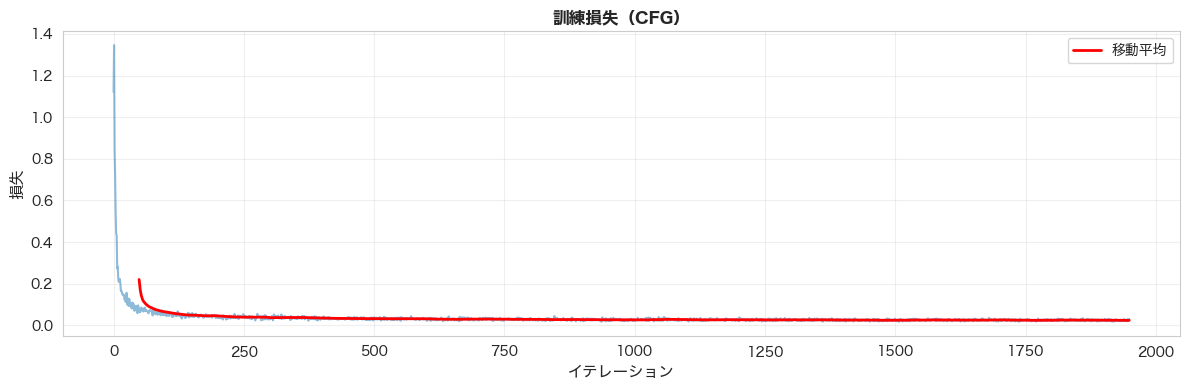

In [7]:
# ============================================================
# 訓練曲線
# ============================================================

plt.figure(figsize=(12, 4))
plt.plot(losses, alpha=0.5)
window = 50
if len(losses) > window:
    moving_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(losses)), moving_avg, color='red', linewidth=2, label='移動平均')
plt.xlabel('イテレーション', fontsize=11)
plt.ylabel('損失', fontsize=11)
plt.title('訓練損失（CFG）', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 4. 条件付き生成

数字 0 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 1 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 2 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 3 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 4 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 5 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 6 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 7 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 8 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

数字 9 を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

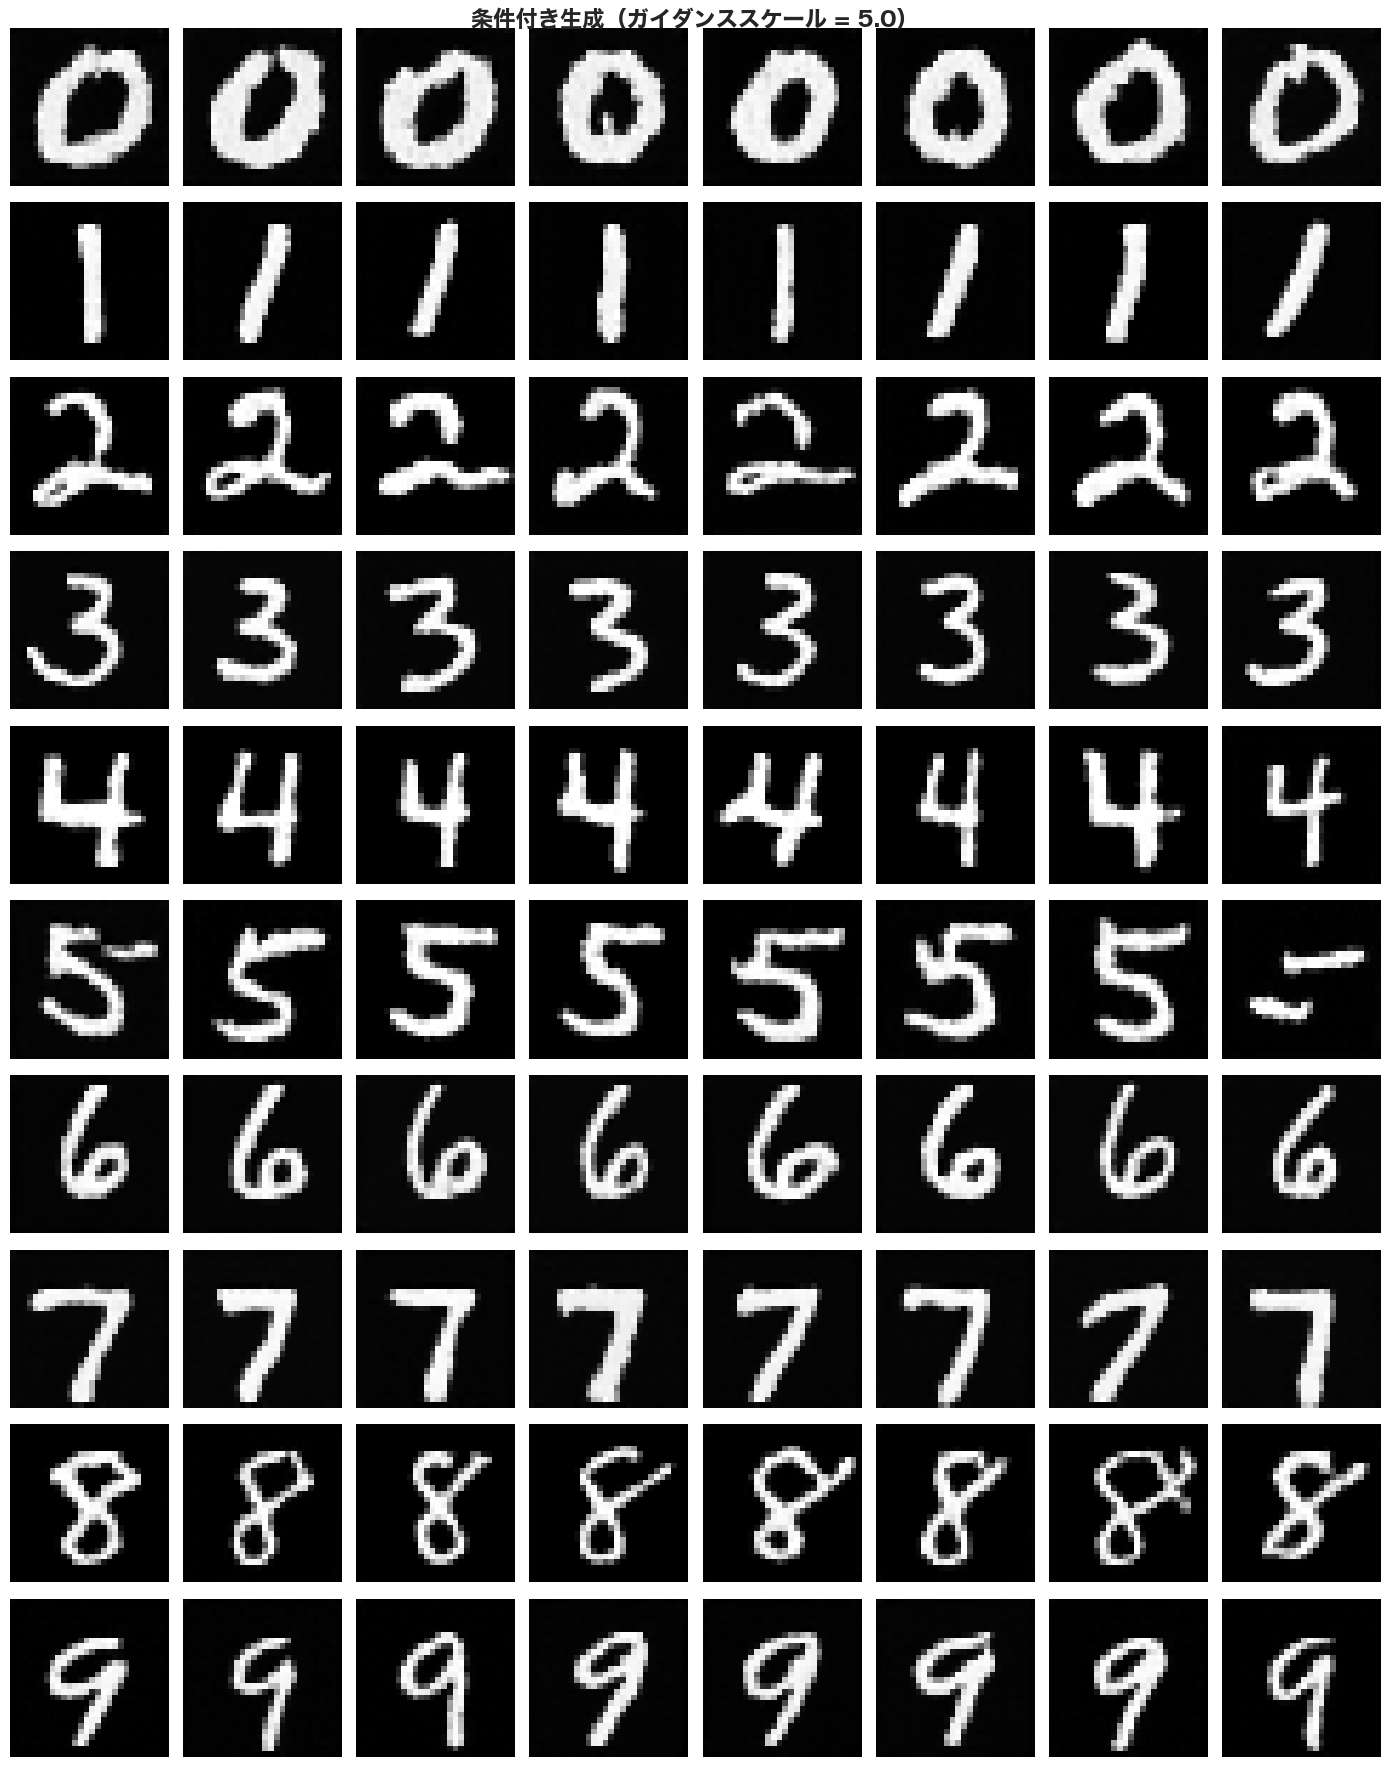

In [8]:
# ============================================================
# 各クラスの生成
# ============================================================

model.eval()

# 各クラス（0-9）を生成
guidance_scale = 5.0

fig, axes = plt.subplots(10, 8, figsize=(14, 18))

for digit in range(10):
    print(f"数字 {digit} を生成中...")
    class_labels = torch.full((8,), digit, device=device, dtype=torch.long)
    
    with torch.no_grad():
        samples = cfg_diffusion.sample(class_labels, guidance_scale=guidance_scale)
    
    for col in range(8):
        img = samples[col].squeeze().cpu().numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        axes[digit, col].imshow(img, cmap='gray')
        axes[digit, col].axis('off')
    
    axes[digit, 0].set_ylabel(f'{digit}', fontsize=14, rotation=0, ha='right', va='center')

plt.suptitle(f'条件付き生成（ガイダンススケール = {guidance_scale}）', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 5. ガイダンススケールの効果

ガイダンススケール = 1.0 を生成中...
ガイダンススケール = 2.0 を生成中...
ガイダンススケール = 3.0 を生成中...
ガイダンススケール = 5.0 を生成中...
ガイダンススケール = 7.5 を生成中...
ガイダンススケール = 10.0 を生成中...


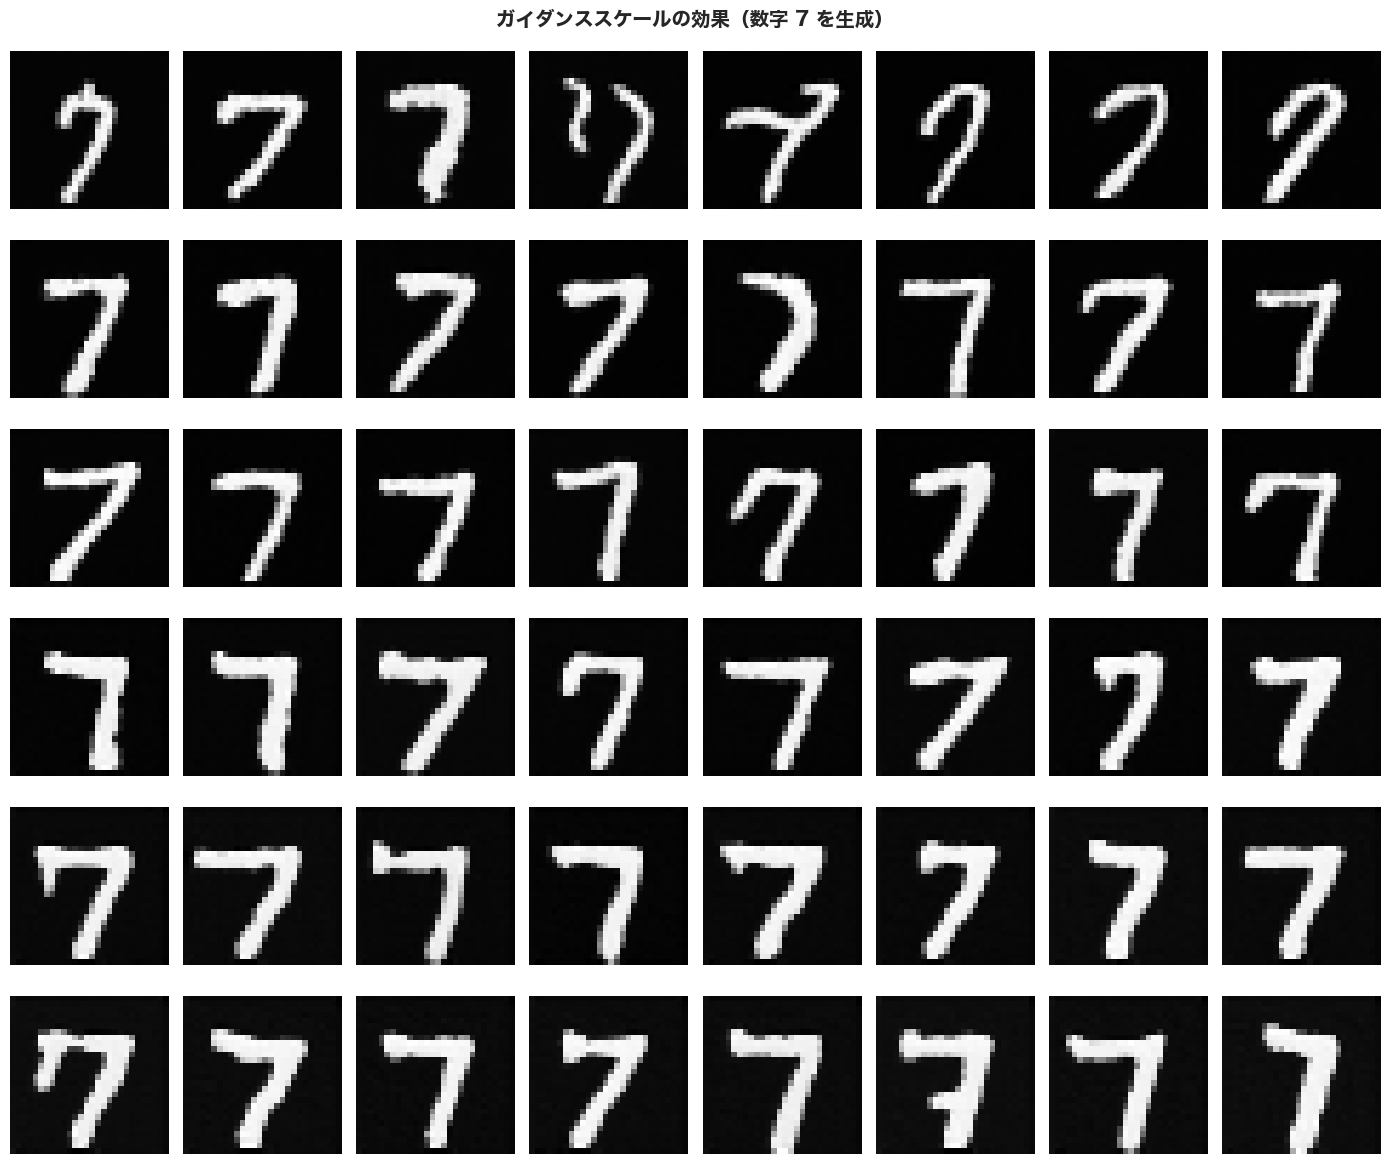


💡 観察:
  - w = 1.0: 条件付きのみ（CFGなし）、多様だが曖昧
  - w = 3-5: バランスが良い
  - w > 7: 条件に忠実だが、過飽和/アーティファクトが発生することも


In [9]:
# ============================================================
# ガイダンススケールの比較
# ============================================================

guidance_scales = [1.0, 2.0, 3.0, 5.0, 7.5, 10.0]
target_digit = 7

fig, axes = plt.subplots(len(guidance_scales), 8, figsize=(14, len(guidance_scales) * 2))

# 同じ初期ノイズを使用
torch.manual_seed(42)
initial_noise = torch.randn(8, 1, 28, 28, device=device)

for row, gs in enumerate(guidance_scales):
    print(f"ガイダンススケール = {gs} を生成中...")
    
    class_labels = torch.full((8,), target_digit, device=device, dtype=torch.long)
    
    # 同じ初期ノイズから開始
    x = initial_noise.clone()
    
    for t in reversed(range(cfg_diffusion.T)):
        x = cfg_diffusion.p_sample(x, t, class_labels, guidance_scale=gs)
    
    for col in range(8):
        img = x[col].squeeze().cpu().numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
    
    axes[row, 0].set_ylabel(f'w = {gs}', fontsize=11)

plt.suptitle(f'ガイダンススケールの効果（数字 {target_digit} を生成）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 観察:")
print("  - w = 1.0: 条件付きのみ（CFGなし）、多様だが曖昧")
print("  - w = 3-5: バランスが良い")
print("  - w > 7: 条件に忠実だが、過飽和/アーティファクトが発生することも")

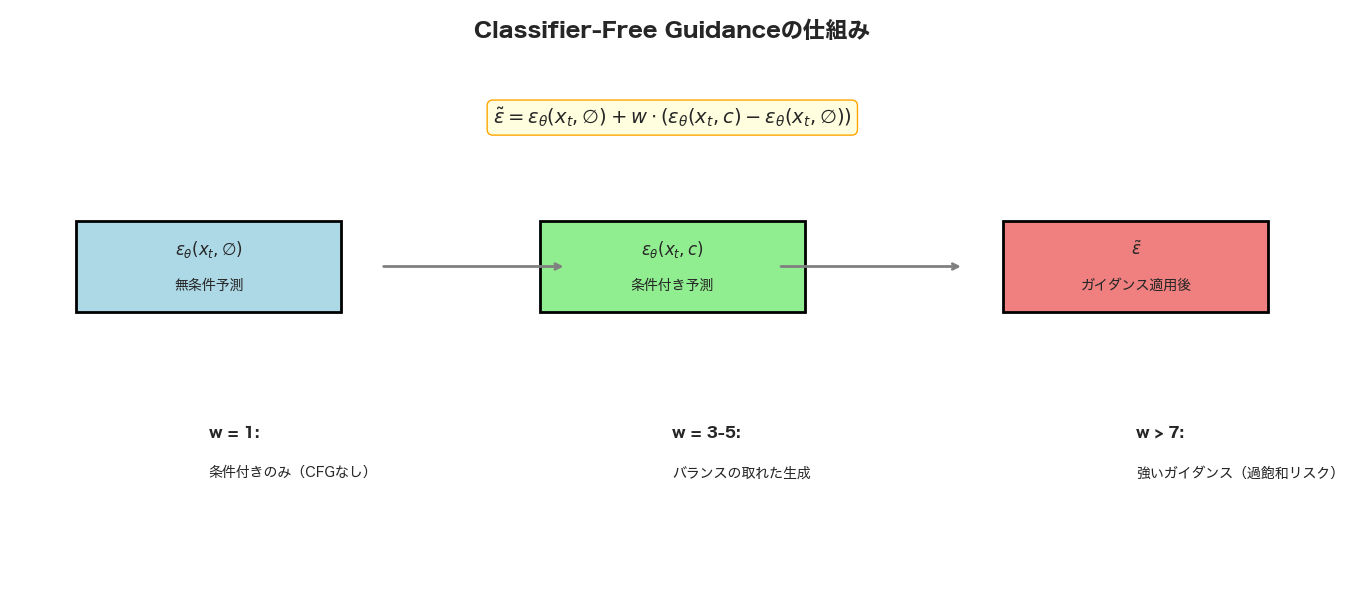

In [10]:
# ============================================================
# CFGの視覚的説明
# ============================================================

fig, ax = plt.subplots(figsize=(14, 6))

# 説明図
ax.text(0.5, 0.95, 'Classifier-Free Guidanceの仕組み', fontsize=16, fontweight='bold',
        ha='center', transform=ax.transAxes)

# 式
ax.text(0.5, 0.8, r'$\tilde{\epsilon} = \epsilon_{\theta}(x_t, \emptyset) + w \cdot (\epsilon_{\theta}(x_t, c) - \epsilon_{\theta}(x_t, \emptyset))$',
        fontsize=14, ha='center', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='orange'))

# コンポーネント
components = [
    (0.15, 0.55, r'$\epsilon_{\theta}(x_t, \emptyset)$', '無条件予測', 'lightblue'),
    (0.5, 0.55, r'$\epsilon_{\theta}(x_t, c)$', '条件付き予測', 'lightgreen'),
    (0.85, 0.55, r'$\tilde{\epsilon}$', 'ガイダンス適用後', 'lightcoral'),
]

for x, y, formula, label, color in components:
    ax.add_patch(plt.Rectangle((x-0.1, y-0.08), 0.2, 0.16, 
                               facecolor=color, edgecolor='black', lw=2,
                               transform=ax.transAxes))
    ax.text(x, y+0.02, formula, fontsize=12, ha='center', transform=ax.transAxes)
    ax.text(x, y-0.04, label, fontsize=10, ha='center', transform=ax.transAxes)

# 矢印と説明
ax.annotate('', xy=(0.42, 0.55), xytext=(0.28, 0.55),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'),
            transform=ax.transAxes)
ax.annotate('', xy=(0.72, 0.55), xytext=(0.58, 0.55),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'),
            transform=ax.transAxes)

# w の説明
w_explanations = [
    ('w = 1', '条件付きのみ（CFGなし）'),
    ('w = 3-5', 'バランスの取れた生成'),
    ('w > 7', '強いガイダンス（過飽和リスク）'),
]

for i, (w, desc) in enumerate(w_explanations):
    ax.text(0.15 + i*0.35, 0.25, f'{w}:', fontsize=11, fontweight='bold', transform=ax.transAxes)
    ax.text(0.15 + i*0.35, 0.18, desc, fontsize=10, transform=ax.transAxes)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

---

## 6. 条件付き vs 無条件の比較

無条件生成...
条件付き生成...


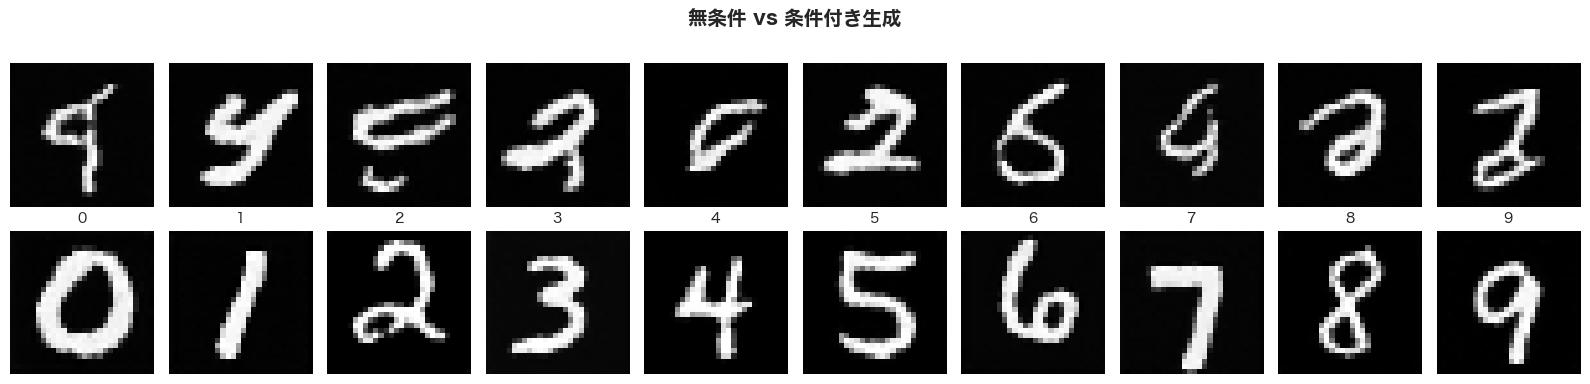

In [11]:
# ============================================================
# 条件付き vs 無条件
# ============================================================

fig, axes = plt.subplots(2, 10, figsize=(16, 4))

# 無条件生成
print("無条件生成...")
with torch.no_grad():
    # class_labels = None で無条件
    x = torch.randn(10, 1, 28, 28, device=device)
    for t in reversed(range(cfg_diffusion.T)):
        x = cfg_diffusion.p_sample(x, t, None, guidance_scale=1.0)
    uncond_samples = x

for col in range(10):
    img = uncond_samples[col].squeeze().cpu().numpy()
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].axis('off')
axes[0, 0].set_ylabel('無条件', fontsize=11)

# 条件付き生成（各数字）
print("条件付き生成...")
with torch.no_grad():
    class_labels = torch.arange(10, device=device)
    x = torch.randn(10, 1, 28, 28, device=device)
    for t in reversed(range(cfg_diffusion.T)):
        x = cfg_diffusion.p_sample(x, t, class_labels, guidance_scale=5.0)
    cond_samples = x

for col in range(10):
    img = cond_samples[col].squeeze().cpu().numpy()
    img = np.clip(img * 0.5 + 0.5, 0, 1)
    axes[1, col].imshow(img, cmap='gray')
    axes[1, col].axis('off')
    axes[1, col].set_title(f'{col}', fontsize=10)
axes[1, 0].set_ylabel('条件付き', fontsize=11)

plt.suptitle('無条件 vs 条件付き生成', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

**条件付き拡散モデル**
- ✓ クラス埋め込みの追加
- ✓ 無条件訓練（ラベルドロップ）
- ✓ 条件付きU-Netの実装

**Classifier-Free Guidance**
- ✓ CFGの数学的理解
- ✓ ガイダンススケールの効果
- ✓ 条件付きサンプリングの実装

### 📊 CFGのまとめ

| パラメータ | 効果 |
|-----------|------|
| `p_uncond = 0.1` | 訓練時に10%の確率でラベルをドロップ |
| `w = 1.0` | CFGなし（条件付きのみ） |
| `w = 3-5` | バランスの取れたガイダンス |
| `w > 7` | 強いガイダンス（過飽和リスク） |

### 📊 CFGの式

$$\tilde{\epsilon}_\theta = \epsilon_\theta(x_t, \emptyset) + w \cdot (\epsilon_\theta(x_t, c) - \epsilon_\theta(x_t, \emptyset))$$

- $\epsilon_\theta(x_t, \emptyset)$: 無条件ノイズ予測
- $\epsilon_\theta(x_t, c)$: 条件付きノイズ予測
- $w$: ガイダンススケール

---

## 🎓 自己評価クイズ

### Q1: なぜ訓練時にラベルをドロップするのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- CFGでは無条件ノイズ予測 $\epsilon_\theta(x_t, \emptyset)$ が必要
- 訓練時にランダムにラベルをドロップすることで、モデルは無条件でもノイズを予測できるようになる
- これにより、1つのモデルで条件付き・無条件の両方を処理できる

</details>

---

### Q2: ガイダンススケール w = 1.0 の意味は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
CFGの式に w = 1.0 を代入：

$\tilde{\epsilon} = \epsilon_{\emptyset} + 1.0 \cdot (\epsilon_c - \epsilon_{\emptyset}) = \epsilon_c$

つまり、条件付きノイズ予測のみを使用（CFGなし）

</details>

---

### Q3: Classifier GuidanceとClassifier-Free Guidanceの違いは？

<details>
<summary>💡 答えを見る</summary>

**答え**:

| Classifier Guidance | Classifier-Free Guidance |
|---------------------|-------------------------|
| 別途分類器が必要 | 追加モデル不要 |
| 分類器の勾配を使用 | 条件付き/無条件の差を使用 |
| 訓練後に適用可能 | 訓練時にラベルドロップが必要 |
| 分類器の品質に依存 | よりシンプルで効果的 |

</details>

---

### ✅ 学習チェックリスト

- [ ] 条件付きU-Netを実装できる
- [ ] CFGの仕組みを説明できる
- [ ] ガイダンススケールの効果を理解している
- [ ] 特定のクラスを生成できる

---

## 🎉 拡散モデルシリーズ完了！

おめでとうございます！これで拡散モデルの基礎から応用まで学習しました。

### 📚 学習した内容

| Notebook | 内容 |
|----------|------|
| 37 | 拡散モデルの理論（基礎） |
| 38 | 拡散モデルの理論（ELBO導出） |
| 39 | U-Netと位置エンコーディング |
| 40 | DDPM実装（基礎編） |
| 41 | DDIM実装（発展編） |
| 42 | Classifier-Free Guidance |

### 🚀 次のステップ

- **Stable Diffusion**: テキストから画像を生成
- **ControlNet**: より精密な制御
- **高解像度生成**: 潜在空間での拡散